# TME 7 : Détection d'objets simples (II) :

> Consignes: le fichier TME7_Sujet.ipynb est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2019/course/view.php?id=4248. Si vous êtes en binôme, renommez-le en TME7_nom1_nom2.ipynb.

N'oubliez pas de sauvegarder fréquemment votre notebook !! ...

Pour chaque questions, écrivez des commentaires brefs et concis lorsque demandé dans les cases **Commentaires**.

In [1]:
### Chargement des modules et des données utiles.

from PIL import Image
from pylab import *
from scipy.signal import convolve2d
from skimage import morphology
from time import process_time

### charger les images et les convertir en tableaux Numpy
rectangle = array(Image.open("images/rectangle.png"))/255

carrelage = array(Image.open("images/carrelage_wikipedia.jpg"))/255
jussieu = array(Image.open("images/Jussieu_wikipedia.jpg"))/255
house = array(Image.open("images/house2.jpg"))/255
#rotate = array(Image.open("images/rotate.png"))
table = array(Image.open("images/table.png"))/255
chaise = array(Image.open("images/chaise.png"))/255

### image synthétique pour mise au point
def image_contours_ligne_simple():
    """ NoneType -> Array
    Construit une image de contours seuillée de taille 500x500 avec une ligne.
    """
    image_contours = zeros((500,500))
    for t in range(200):
        image_contours[ t + 100, t] = 1
    return image_contours

### Fonctions d'affichage
def affichage_14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
    Dffectue entre 1 et 4 affichages avec leurs titres, pour des images ou courbes
    
    Paramètres :
      - liste des affichages (entre 1 et 4)
      - liste des titres (entre 1 et 4, autant que de affichages), optionnelle    
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('affichage_14 nécéssite 1 à 4 entrées en paramètre')        
        
    if nb_affichages != len(titres):
        raise ValueError('affichage_14 nécéssite autant de titres que d\'affichages')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    show()


def trace_image_et_cercles(image, liste_cercles):
    """
    Array*list[tuple(int,int,int)] -> NoneType
    Affichage supperposé d'une image et de cercles.
    """
    fig, ax = subplots()
    imshow(image, cmap=cm.gray)
    for cercle in liste_cercles:
        rayon = cercle[0]
        X_c = cercle[2]
        Y_c = cercle[1]
        circle1 = Circle((X_c, Y_c),rayon,color='r', fill=False)
        gcf().gca().add_artist(circle1)
        
    set_xlim((0, image.shape[1]))
    set_ylim((image.shape[0], 0))
    set_axis_off()
    set_title('Cercles détectés')
    show()

### Fonctions de chronométrage
mytime = 0
def tic():
    global mytime
    mytime = process_time()
def tac():
    global mytime
    print (process_time()-mytime)
    mytime = process_time()


## Exercice 1 — Transformée de Hough: détection de droites

In [8]:
def nb_min_letters(chaine):
    cpt=0
    for s in chaine:
        if(s.islower()):
            cpt+=1
    return cpt
#nb_min_letters("mdr")
#nb_min_letters("LoooOOL!!!")
nb_min_letters("Semi-annuel")

e
m
i
a
n
n
u
e
l
9


9

### Question 1 : Calcul de l'accumulateur à partir d'une image de contours, version boucle

On dispose d'une image de contours binarisée. On cherche à calculer la transformée de Hough correspondant.

1. Écrire la fonction ```houghl()``` qui renvoie la transformée de Hough pour les droites de l'image de contours binarisée. On utilisera l'algorithme données en TD. 

La fonction prendra pour arguments:
- l'image de contours: adges, 
- le nombre de pas pour $\theta$: ``ntheta``,
- le nombre de pas pour $\rho$: ``nrho``,
- la tolérance: ``tol`` (qui correspond au test $|x\cos\theta+y\sin\theta-\rho|<tol$).

**Conseil 1:** remplacer le parcours de l'image par une boucle sur les tableaux d'indices ``X`` et ``Y`` des valeurs non nulles de l'image. On utilisera pour cela la fonction Numpy ```nonzero()``` et la fonction Python ```zip()```. 

**Conseil 2:** le calcul des cosinus et sinus est coûteux. En remarquant que les 4 boucles imbriquées sont indépendantes les unes des autres et qu'on peut les permuter,  faire en sorte de ne calculer **qu'une seule fois** les valeurs cosinus et sinus pour chaque élément de l'accumulateur de Hough.

In [3]:

"""
nonzero: computes the indices of nonzero elements
zip(): parallel iterator
image de contour binarisé , valeurs \in {0, 1}
"""
from math import * 
#on consière que l'origine est le pot d'indice (0,0)
def appartientaladroite(pixel, cos, sin ,rho, tol):
    x=pixel[0]
    y=pixel[1]
    return np.abs((x*cos+y*sin)-rho)<tol
    
"""
entrées: I image de contours binarisés  
        ntheta: nombre de pas theta
        nrho: nombre de pas rho
        tol: nécessaire pour le test
"""
def houghl(I,ntheta,nrho,tol):
    """ Array*int*int*float -> Array[int] """
    #Accumulateur
    H=np.zeros((ntheta, nrho))
    tabX, tabY=np.nonzero(I)
    (n,m)=shape(I)
    rmax=sqrt(n*n+m*m)
    theta=np.linspace(-np.pi/2,np.pi, ntheta)
    rho=np.linspace(0, rmax, nrho)
    
    for j in range(ntheta):
        cos=np.cos(theta[j])
        sin=np.sin(theta[j])
        for r in range(nrho):
            for p in zip(tabX, tabY):
                if(appartientaladroite(p,cos,sin,rho[r],tol )==True):
                    H[j][r]+=1

    return H.transpose()

2. Tester la fonction ```houghl()``` en l'appliquant à l'image de contours binarisée synthétique très simple générée par la fonction ```image_contours_ligne_simple()```. Afficher l'accumulateur de Hough. Chronométrez également le temps de calcul de la fonction ```hough()```, en prenant des valeurs différentes pour nt et nr. Rappel TD: idéalement nr vaut la longueur d'une diagonale de l'image à traiter et nt pourrait valoir 360 pour avoir une précision de 1 degré, dans un repère polaire. Conseil: essayer d'abord avec des valeurs nettement plus petites, puis augementer les et observer les temps de calcul. Donner un ordre de grandeur de la complexité de cet algorithme.

(500, 500)
19.039670379


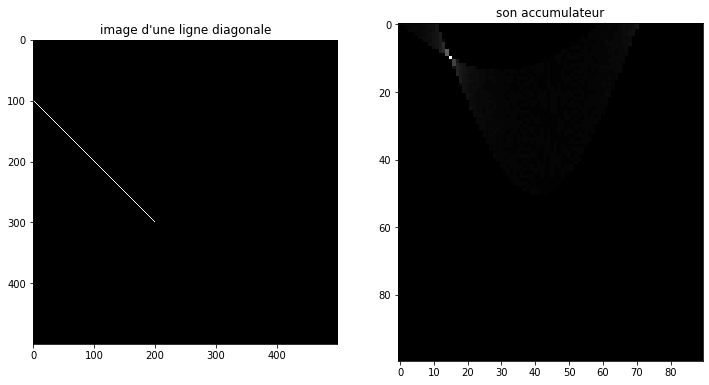

In [4]:
l=image_contours_ligne_simple()
print(l.shape)
tic()
acc=houghl(l,90 , 100,1)
tac()
affichage_14([l, acc], ["image d'une ligne diagonale", "son accumulateur"])


90.328640362


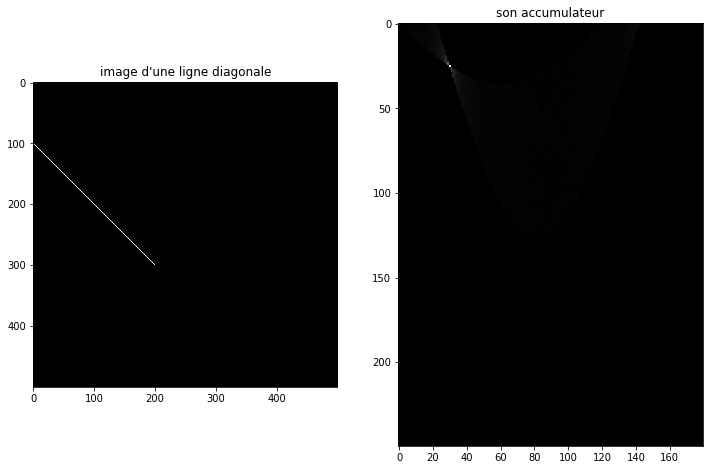

In [5]:
tic()
acc=houghl(l,180 , 250,1)
tac()
affichage_14([l, acc], ["image d'une ligne diagonale", "son accumulateur"])


203.96089979099997


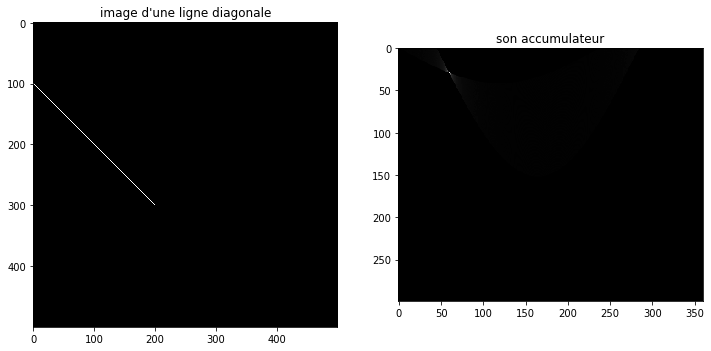

In [6]:

tic()
acc=houghl(l,360 , 300,1)
tac()
affichage_14([l, acc], ["image d'une ligne diagonale", "son accumulateur"])



344.65135786900004


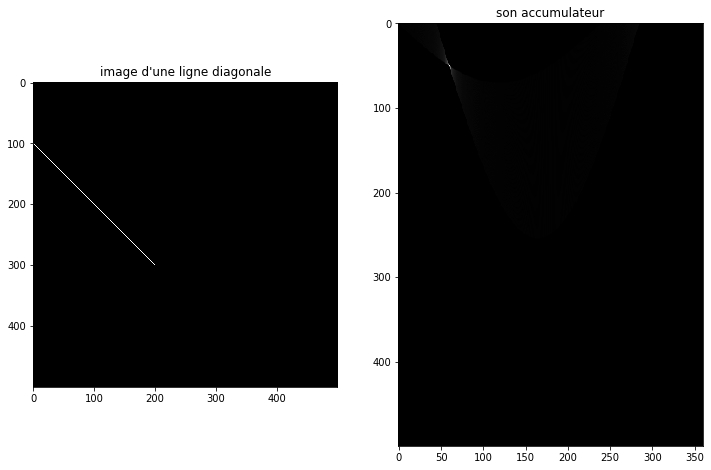

In [7]:
tic()
acc=houghl(l,360 , 500,1)
tac()
affichage_14([l, acc], ["image d'une ligne diagonale", "son accumulateur"])


## Commentaire
plus on choisit des valeurs grandes pour ntheta et nrho plus l'algorithme est lent car il y a beaucoup d'itérations qui sont faites

### complexité: 
si n= taille, L=longueur de l'image, l=largeur de l'image,
O(nthta nrho l L) donc approximativement O(n⁴)
la fonction n'est donc pas efficace, le calcul est trop lent!

### Question 2: optimisation de la fonction ``houghl()``

Vous avez du constater que le temps de calcul est très long et cela même pour une image très simple. Le temps dépend donc largement des valeurs ```ntheta``` et ```nrho```.
Puisque les 4 boucles de l'algorithme (boucles sur indice de ligne, de colonne de l'image de contours à traiter, d'angle et de distance à l'origine) sont indépendantes, on peut imbriquer les parcours sur l'image à l'intérieur du parcours de l'accumulateur de Hough.

On pourra alors constater qu'il revient au même de calculer à l'avance les différentes valeurs de $\rho$ et $\theta$ et de les placer dans des tableaux. En effet, écrire :
````
for r in range(nrho):
    for t in range(ntheta):
       calcul sur t, indépendemment de r
       calcul sur r, indépendemment de t
````
revient à écrire:
`````
for r in range(nrho):
    for t in range(ntheta):
        CT[r,t] = f(t)
        CR[r,t] = g(r)
`````
Le calcul des tableaux ``CT`` et ``CR`` peut-être effectué uniquement par appel Numpy **sans utiliser de boucle**: le tableau ``CT`` voit chacune de ses colonnes **identiques** et ``CR`` ses lignes **identiques**. 

1. En utilisant à bon escient les fonctions ``ones()`` et ```linspace()```, puis facultativement ```meshgrid()```, ou encore plus simplement en gardant les boucles, construire les tableaux ```R```, ```C``` et ```S```. Chaque ligne du tableau ```R``` décrit les mêmes suites de valeurs de $\rho$. Chaque colonne des tableaux ```C``` et ```S``` décrivent les mêmes suites de valeurs de $\cos\theta$ et $\sin\theta$. On rappelle que $\rho$ et $\theta$ vérifient l'équation $x\cos\theta + y\sin\theta = \rho$  pour $x$ et $y$ les coordonnées d'un point de contours dans l'image. Pour la version boucle, quelle est la complexité ? Est-elle acceptable pour un script Python ?

In [31]:
# pour tester
nrho,ntheta = 4,6
n,m = 50,50

na, nb = (5, 3)  

rmax=sqrt(n*n+m*m)
theta=np.linspace(-np.pi/2,np.pi, ntheta)
rho=np.linspace(0, rmax, nrho)
C,R=np.meshgrid(np.cos(theta),rho)
S,R = np.meshgrid(np.sin(theta),rho)


print("-------------------")
print(C)

print("-------------------")
print(S)
 
print("-------------------")
print(R)  


-------------------
[[ 6.12323400e-17  8.09016994e-01  9.51056516e-01  3.09016994e-01
  -5.87785252e-01 -1.00000000e+00]
 [ 6.12323400e-17  8.09016994e-01  9.51056516e-01  3.09016994e-01
  -5.87785252e-01 -1.00000000e+00]
 [ 6.12323400e-17  8.09016994e-01  9.51056516e-01  3.09016994e-01
  -5.87785252e-01 -1.00000000e+00]
 [ 6.12323400e-17  8.09016994e-01  9.51056516e-01  3.09016994e-01
  -5.87785252e-01 -1.00000000e+00]]
-------------------
[[-1.00000000e+00 -5.87785252e-01  3.09016994e-01  9.51056516e-01
   8.09016994e-01  1.22464680e-16]
 [-1.00000000e+00 -5.87785252e-01  3.09016994e-01  9.51056516e-01
   8.09016994e-01  1.22464680e-16]
 [-1.00000000e+00 -5.87785252e-01  3.09016994e-01  9.51056516e-01
   8.09016994e-01  1.22464680e-16]
 [-1.00000000e+00 -5.87785252e-01  3.09016994e-01  9.51056516e-01
   8.09016994e-01  1.22464680e-16]]
-------------------
[[ 0.          0.          0.          0.          0.          0.        ]
 [23.57022604 23.57022604 23.57022604 23.57022604 23.57

## Réponse:
tel que mentionné ci-dessus, la compléxisté est O(n⁴) est trop grande, donc pas acceptable pour un script python

2. Soit $(x_1,y_1),..,(x_n,y_n)$ la liste des $n$ points de contours dans l'image de contours binarisée que l'on doit analyser, remarquer alors que $H = \sum_{i=1}^n |x_i C + y_i S - R| <= tol$. En déduire une version 2 de la fonction ``houghl_opt()``. Comparer le temps d'exécution avec la version précédente. 

In [9]:
# Entrée: edges itérateur construit avec zip sur les valeurs du contours (non nulles)
def houghl_opt(edges,ntheta,nrho,tol):
    """ Array*int*int*float -> Array[int] """
    #Accumulateur
    H=np.zeros((nrho, ntheta))
   
    # nous n'avons pas l'image en paramètre, nous ne pouvons donc pas calcluer rmax comme suit:(n,m)=shape(I)
    #rmax=sqrt(n*n+m*m)
    #on doit donc trouver un autre moyen
    #on multiplie * 1.4 pour être surs que la valeur est assez grande
    #np.max retourne le maximum sur tout le tableau
    rmax=1.4*np.max(edges)
    theta=np.linspace(-np.pi/2,np.pi, ntheta)
    rho=np.linspace(0, rmax, nrho)
    
    C,R=np.meshgrid(np.cos(theta),rho)
    S,R = np.meshgrid(np.sin(theta),rho)
    tol_tab=np.ones((nrho, ntheta))*tol
    
    for (x,y) in edges:
        #On fait une comparaison entre deux tableaux numpy ( revient à comparer les valeurs une à une )
        Comp=np.abs(y*C+x*S-R)<tol_tab
        Comp=Comp.astype(float)
        #les cases dans comp pour qui la condition est verifiés sont à 1
        #il suffit donc de faire une addition case à case avec l'accumulateur pour incrémenter les bonnes valeurs
        H+=Comp

    return H


## Tests

0.052836551000041254


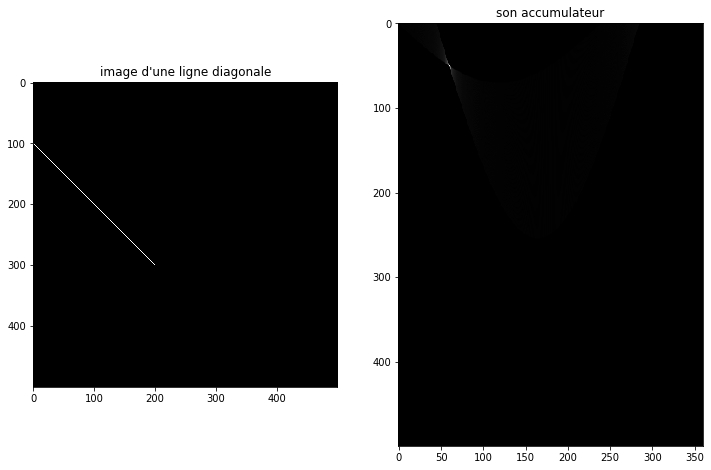

In [10]:

tabX, tabY=np.nonzero(l)
edges=[(x,y) for (x,y) in zip(tabX, tabY)]
tic()
acc2=houghl_opt(edges,90 , 100,1)
tac()
affichage_14([l, acc], ["image d'une ligne diagonale", "son accumulateur"])


0.15867690000004586


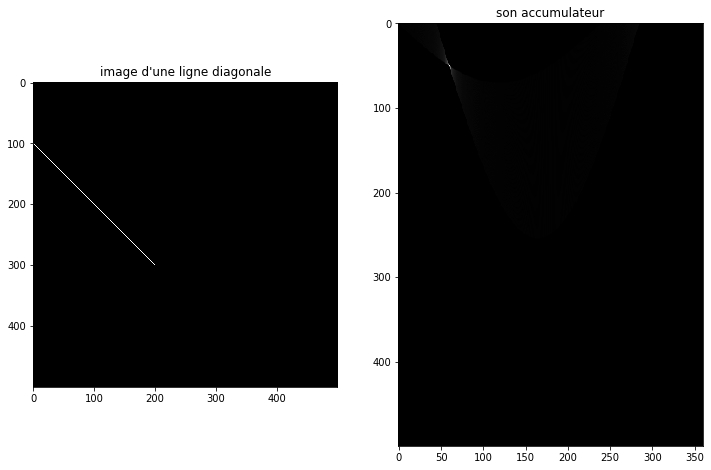

In [11]:
tic()
acc2=houghl_opt(edges,180 , 250,1)
tac()
affichage_14([l, acc], ["image d'une ligne diagonale", "son accumulateur"])


0.26484195800003363


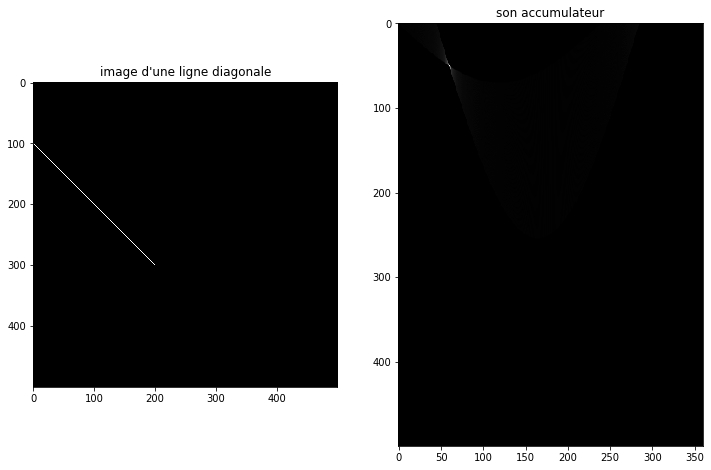

In [12]:
tic()
acc2=houghl_opt(edges,360 , 300,1)
tac()
affichage_14([l, acc], ["image d'une ligne diagonale", "son accumulateur"])


0.8211033080000334


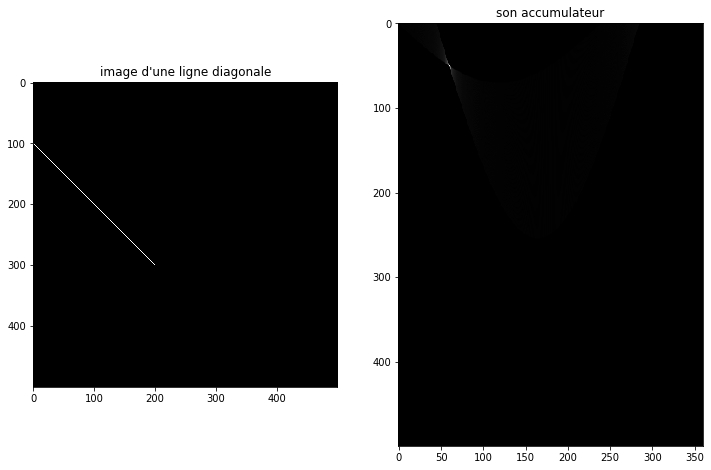

In [13]:
tic()
acc2=houghl_opt(edges,360 , 500,1)
tac()
affichage_14([l, acc], ["image d'une ligne diagonale", "son accumulateur"])


## Commentaire:
l'utilisation de la deuxième méthode est bien plus rapide, elle est instentanée ( avec un taux d'amélioration conséquent de 321/0.046 pour le 4éme test par exemple)

### Question 3 : Recherche des $N$ plus grands maxima locaux

On cherche ici à rechercher les $N$ plus grands maxima locaux de l'accumulateur de Hough afin de déterminer quelles sont les droites détectées.

1. Écrire une fonction ```maxloc_N(H,N)``` qui calcule les ``N`` maxima locaux de l'accumulateur ``H``. La fonction est similaire à celle du TME 6 (```maxloc()```) avec une différence toutefois : elle retourne une liste des coordonnées des ``N`` premiers maxima locaux **trié** par valeurs décroissantes qu'ils prennent dans ```H```. On rappelle que Python possède une fonction ```sorted()``` opérant sur les listes.

In [59]:
if (1<2 * 1<5 * 1<0):
    print('ok')
bool=True
print(bool==True)

True


In [19]:
import operator
#Entrées: N: nb maxima locaux de H à calculer
def maxloc_N(H, N): 
    """ Array[int]*int -> list[tuple(int,int)] """
    h, w=H.shape
    maximas=[]
    res=[]
    for i in range(1,h-1):
        for j in range(1,w-1):
            bool=True
            for k in range(-1, 2):
                for l in range(-1, 2):
                    bool=bool*(H[i][j]>=H[i+k][j+l])
            if (bool==True):
                maximas.append((i,j,H[i][j]))
                
    maximas.sort(key=operator.itemgetter(2),reverse=True)
    #on veut récupérer les coordonnées des N premières valeurs
    for i in range(N):
        res.append((maximas[i][0], maximas[i][1]))
    return res

2. Tester cette fonction sur l'accumulateur calculé à la question 1 (ou 2).

In [20]:
result=maxloc_N(acc2, 1 )
print (result)

[(85, 299)]


3. Écrire une fonction ``hougl_intersect(l,c,H,I)`` qui calcule l'intersection de la droite de coordonnée ``(l,c)`` dans l'accumulateur ``H`` avec les bords de l'image ``I``. La fonction doit calculer les valeurs $(\rho,\theta)$ correspondant à ``(l,c)`` puis calculer une liste de 4 coordonnées qui correspond aux intersections de la droite  $(\rho,\theta)$ avec les droites $x=0$, $x=m-1$, $y=0$ et $y=m-1$ dans le plan image. La fonction ne retournera que les intersections qui sont dans le plan de l'image (normalement 2) sous forme de deux listes: la première liste donc les indices de colonne, et la seconde, les indices de ligne.

In [68]:
# retour: tuple de deux tableaux, un pour les coordonnés sur x et un pour les coordonnés sur y
def houghl_intersect(l,c,H,I):
    """ int*int*Array[int]*Array -> tuple[list[int],list[int]] """
    n, m=I.shape
    # Initialisation
    tabX, tabY=np.nonzero(I)
    edges=[(x,y) for (x,y) in zip(tabX, tabY)]
    rmax=1.4*np.max(edges)
    theta=np.linspace(-np.pi/2,np.pi, H.shape[1])
    rho=np.linspace(0, rmax, H.shape[0])
    
    #calcul de cosinus et sinus une seule fois
    cos=np.cos(theta[c])
    sin=np.sin(theta[c])
    
    L=rho[l]
    
    #On distingue 4 cas possibles dont 2 seront obligatoirement vérifiés
    #cas 1: coupe bord gauche
    y1=0
    x1=(L/cos)
    
    #cas 2: coupe le bord droit
    y2=m-1
    x2=((L-y2*sin)/cos)
    
    #cas 3: coupe le bord haut
    x3=0
    y3=(L/sin)
    
    #cas 4: courpe le bord bas
    x4=n-1
    y4=((L-x4*cos)/sin)
    
    #Il faut distinguer quels cas sont les bons
    resX=[]
    resY=[]
    if( x1<n and x1>=0):
        resX.append(x1)
        resY.append(y1)
        
    if( x2<n and x2>=0):
        resX.append(x2)
        resY.append(y2)
    
    if( y3<m and y3>=0):
        resX.append(x3)
        resY.append(y3)
    
    if( y4<m and y4>=0):
        resX.append(x4)
        resY.append(y4)
        
    if(len(resX)!=2):
        print("Error, this shouldn't happen")
        
    return resX, resY
        

4. Écrire une fonction ``houghl_draw(H,N,I)`` qui affiche l'image ``I`` et les ``N`` segments de droites correspondant aux $N$ premiers maxima locaux de $H$. Testez là sur l'accumulateur précédent. Si le résultat n'est pas très précis, recalculer l'accumulateur de Hough avec plus de précision.

In [69]:
def  houghl_draw(H,N,I):
    """ Array[int]*int*Array -> NoneType"""
    plt.imshow(I, cmap='gray')
    #plt.gray()
    droites=maxloc_N(H,N)
    for (r, t) in droites:
        InterX, InterY=houghl_intersect(r,t, H, I)
        plt.plot(InterX, InterY, color='blue')
    plt.show()
    plt.figure()

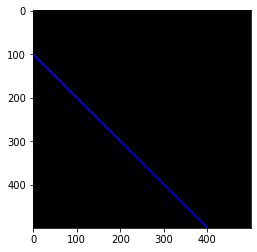

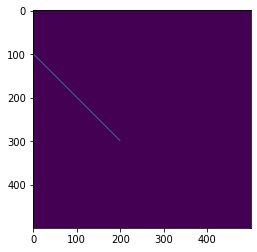

In [70]:
## Test
houghl_draw(acc2,1,l)
imshow(l)

## Commentaire
La droite construite correspond bien à la droite déja présente dans l'image de base

### Question 4 : Détection de lignes sur une image.

On cherche maintenant à détecter les lignes dans une image quelconque à l'aide de la méthode de Hough.

1. Écrire une fonction ``edges(I,s)`` qui réalise une détection de contours sur l'image ``I`` à l'aide des opérateurs de Sobel et de la fonction ``convolve2d()``. On effectuera un seuillage binaire sur la norme du gradient, le seuil sera donné par ``s``. Enfin, on utilisera la fonction ```morphology.thin()``` du module ``skimage`` qui permet de réalisé un affinage des contours. La fonction retournera la carte des contours affinés.



In [94]:
def edges(I,s):
    """ Array*float -> Array[bool] """
    #Sorbel filter
    sobelX=[[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]
    sobelY=[[1, 2, 1],[0, 0, 0],[-1, -2, -1]]
    # contours selon l'axe y
    Ix_conv=convolve2d(I, sobelX, mode='same')
    # contours selon l'axe x
    Iy_conv=convolve2d(I, sobelY, mode='same')
    # on additionne les deux images pour avoir les contours selon les deux axes
    I_conv=np.abs(Ix_conv)+np.abs(Iy_conv)
    #seuillage
    I_res=I_conv>s
    I_res=I_res.astype(int)
    I_res=morphology.thin(I_res)
    return I_res

2. Tester la fonction ``edges()`` sur l'image ``rectangle.png``. Afficher l'image des contours binarisée.

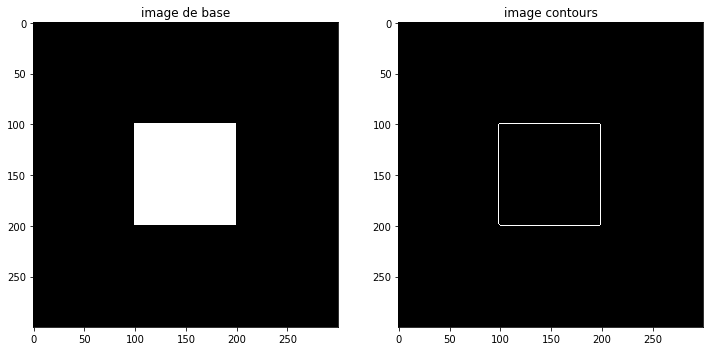

In [96]:
contours=edges(rectangle, 1)
affichage_14([rectangle, contours], ["image de base", "image contours"])

## Commentaire
Le contour carré du rectangle a bien été détécté

3. Calculer et afficher l''accumulateur de Hough pour cette image. On utilisera la version optimisée du détecteur de Hough ainsi que les valeurs `ntheta`=360 et `nrho` = longueur diagonale de l'image. Commenter l'aspect de l'accumulateur.

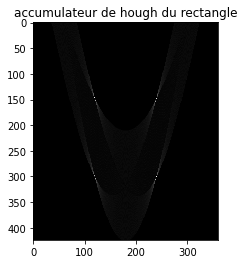

In [97]:
X, Y=np.nonzero(contours)
edg=[ (x, y) for (x,y) in zip(X, Y)]
n,m=contours.shape
nrho=int(np.sqrt(n*n+m*m))

H=houghl_opt(edg,360 , nrho ,0.6)
affichage_14([H],["accumulateur de hough du rectangle"])

## Commentaire
On remarque 4 points très blancs comparés aux autres dans l'accumulateur, ce qui veut dire que les droites ayant pour rho et theta les coordonnées de ces points très blancs dans l'accumulateur sont celles qui intersectent le plus de points, leur nombre est de 4 et ceci correspond très bien à l'image rectangle car on a bien 4 droites formant les contours.

4. Afficher les coordonnées et valeurs des premiers maxima locaux. Pour obtenir un bon résultat, il faut probablement avoir une bonne précision sur les valeurs de $\theta$ pour une tolérance faible (<1), une tolérance trop peu faible implique des détections multiples pour le même segment de droite dans l'image. Reconstruire et afficher les 4 droites détectées dans l'accumulateur.

In [98]:
print("coordonéées des maximas locaux:")
print(maxloc_N(H, 4))



coordonéées des maximas locaux:
[(151, 239), (300, 240), (302, 120), (146, 119)]


## Commentaire
On choisit d'en afficher 4 pour détecter les 4 contours

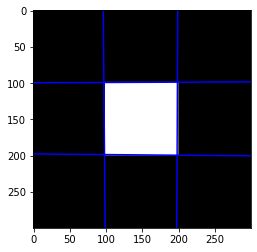

<Figure size 432x288 with 0 Axes>

In [99]:
houghl_draw(H,4,rectangle)

## Commentaire:
La figure ci-dessus montre que les de droites de contours détectés par notre fonction correspondent bien aux contours du rectangle présent dans l'image de base

### Question 5: expérimentation
Tester vos codes sur les images ``carrelage.png``, ``jussieu.png``, ``chaise.png``, ``table.png`` et ``house2.png``.

In [106]:
def contours(I):
    cont=edges(I, 1)
    X, Y=np.nonzero(cont)
    edg=[ (x, y) for (x,y) in zip(X, Y)]
    n,m=cont.shape
    nrho=int(np.sqrt(n*n+m*m)*2)
    H=houghl_opt(edg,720 , nrho ,0.6)
    houghl_draw(H,10,I)

Image carrelage taille (349, 454)
Error, this shouldn't happen
Error, this shouldn't happen


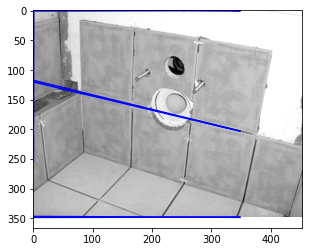

81.15332213200008
Image jussieu taille (500, 500)
Error, this shouldn't happen
Error, this shouldn't happen


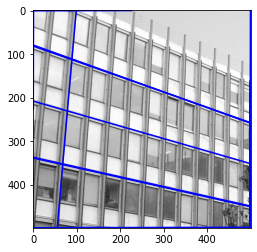

446.8796810810002
Image chaise taille (707, 500)
Error, this shouldn't happen
Error, this shouldn't happen
Error, this shouldn't happen


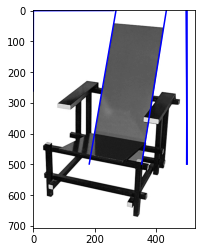

159.73937712399993
Image table taille (500, 500)
Error, this shouldn't happen
Error, this shouldn't happen


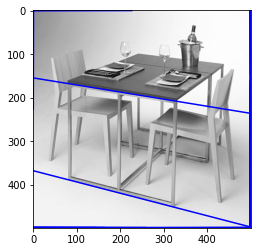

201.59719757599987
Image house taille (256, 256)
Error, this shouldn't happen
Error, this shouldn't happen
Error, this shouldn't happen
Error, this shouldn't happen


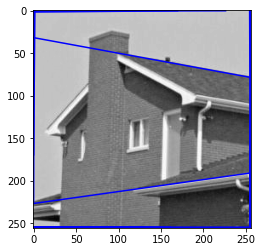

31.70522791800022


<Figure size 432x288 with 0 Axes>

In [107]:
images = [carrelage,jussieu,chaise,table,house]
titres = ["carrelage","jussieu","chaise","table","house"]

for img,titre in zip(images,titres):
    tic()
    print("Image",titre,"taille",img.shape)
    contours(img)
    #edges(img,1)
    tac()


## Exercice  2 : Détection de cercles (bonus)

Implémentez une détection de cercles par la méthode de Hough en adaptant ce qui a été fait dans l'exercice précédent.

- Vous pourrez restreindre la détection aux cercles de rayon inférieur à rayon_max et supérieur à rayon_min.
- On limitera la détection aux cercles dont le centre est dans l'image.
- Il est nécessaire de normaliser l'accumulateur par le périmètre du cercle pour ne pas favoriser la détection de grands cercles.




In [ ]:
# Données
lune = array(Image.open("images/Lune.png"))
cible = array(Image.open("images/cible.png"))
pieces = array(Image.open("images/pieces.png"))
table = array(Image.open("images/table.png"))
chaise = array(Image.open("images/chaise.png"))
velo = array(Image.open("images/Bicyclette_de_Lawson.png").convert('L'))

# image synthétique 
def cercle_simple():
    """ NoneType -> Array
    Construit l'image 200x200 d'un disque de rayon 20 centré. 
    """
    image_contours = zeros((200,200))
    r = 20
    for angle in arange(0,360)*pi/180:
        x = int(round(r*cos(angle))) + 100
        y = int(round(r*sin(angle))) + 100
        image_contours[x,y] = 1
    return image_contours


def trace_image_et_cercles(image, liste_cercles):
    """
    Array*list[tuple(int,int,int)] -> NoneType
    Affichage supperposé d'une image et de cercles.
    """
    fig, ax = subplots()
    imshow(image, cmap=cm.gray)
    for cercle in liste_cercles:
        rayon = cercle[0]
        X_c = cercle[2]
        Y_c = cercle[1]
        circle1 = Circle((X_c, Y_c),rayon,color='r', fill=False)
        gcf().gca().add_artist(circle1)
    axis('off')
    title('Cercles détectés')
    show()


In [ ]:
# mise au point sur cette image
cercle = cercle_simple()


def houghc(img, r_min, r_max,tol):
    """ Array[bool]*int*int*float -> Array """
    
                

def maxloc_houghc(H,N):
    """ Array*int -> list[tuple(int,int,int)]"""
